In [1]:
import pandas as pd

import tensorflow as tf
import numpy as np
from keras import layers
from keras.models import load_model, Model,Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from datetime import datetime
from livelossplot.inputs.tf_keras import PlotLossesCallback


import seaborn as sns #https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b  because of the dataset size
import statsmodels.api as sm

from tensorflow.python.client import device_lib

import cv2
from PIL import Image
import pickle
from sklearn.metrics import multilabel_confusion_matrix

import sys
sys.path.append("..")


2024-04-03 11:51:29.957147: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 11:51:29.979117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 11:51:29.979141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 11:51:29.980039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 11:51:29.984157: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(device_lib.list_local_devices())
print("Num GPUs Available: ", (tf.config.experimental.list_physical_devices()))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1059454459401990422
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 21121138688
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2038776380843240183
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU


2024-04-03 11:51:31.345589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 11:51:31.371873: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 11:51:31.371990: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [4]:
x_train.shape, y_train.shape


((60000, 28, 28), (60000,))

In [5]:
train_df = pd.DataFrame({'image': [img for img in x_train]})
train_df["label"] = y_train

test_df = pd.DataFrame({'image': [img for img in x_test]})
test_df["label"] = y_test

train_df

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",9
...,...,...
59995,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
59996,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
59997,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5
59998,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6


In [6]:
test_df.head()

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4


# Checking classes

In [7]:
np.sort(train_df.label.unique().tolist())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
np.sort(test_df.label.unique().tolist())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

We have all classes in both datasets.
What about the frequence ? 


<Axes: >

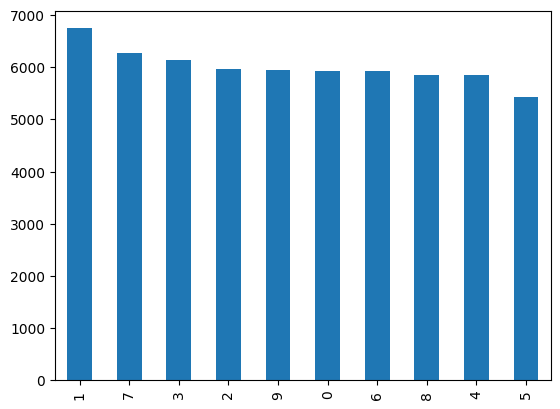

In [9]:
train_df.label.value_counts().plot(kind="bar")

<Axes: >

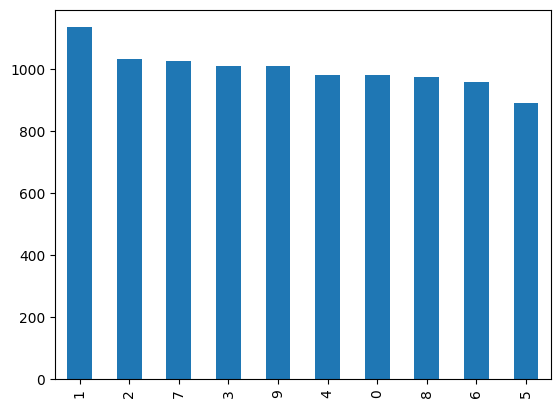

In [10]:
test_df.label.value_counts().plot(kind="bar")

# Defining the baseline (human level performance) and checking where we are right now with a rough model

HLP Accuracy : 99.87%
Loss : categorical cross entropy 

https://arxiv.org/pdf/2001.09136v6.pdf model architecture that achieved the best accuracy. Let's check where we are without data processing.


Shaping the inputs

In [11]:
stage = "rough"

In [12]:
train_df.image.values[0].shape

(28, 28)

(28, 28, 3)


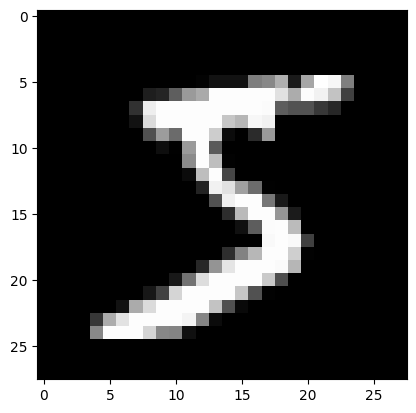

In [13]:
img = Image.fromarray((train_df.image.values[0]).astype(np.uint8)).convert('RGB')
plt.figure()
img = np.asarray(img)
plt.imshow(img)
print(img.shape)

In [14]:
train_df["images_rgb"] = train_df.image.apply(lambda img : np.asarray(Image.fromarray((img).astype(np.uint8)).convert('RGB')) )
train_df.images_rgb.values[0].shape

(28, 28, 3)

In [15]:
test_df["images_rgb"] = test_df.image.apply(lambda img : np.asarray(Image.fromarray((img).astype(np.uint8)).convert('RGB')) )

test_df.images_rgb.values[0].shape

(28, 28, 3)

In [16]:
W = train_df.images_rgb.values[0].shape[0]
H = train_df.images_rgb.values[0].shape[1]

train_input = np.array([img for img in train_df.images_rgb.values]).reshape(len(train_df), W, H, 3)
test_input = np.array([img for img in test_df.images_rgb.values]).reshape(len(test_df), W, H, 3)

train_input[0].shape, test_input[0].shape

((28, 28, 3), (28, 28, 3))

In [17]:
train_input.shape, y_train.shape, test_input.shape, y_test.shape

((60000, 28, 28, 3), (60000,), (10000, 28, 28, 3), (10000,))

In [18]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(W, H, 3)))#128
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(W, H, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(160, (3, 3), activation='relu', input_shape=(W, H, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.00001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['sparse_categorical_accuracy'])

In [19]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/{stage}/")

# model.fit(train_input, 
#           y_train , 
#           #validation_split= 0.05, 
#           validation_data=(test_input, y_test),
#           epochs= 150, 
#           batch_size = 1024,
#           callbacks=[tensorboard_callback]
#           )
# model.save_weights('./checkpoints/model')
model.load_weights('./checkpoints/model')


The best result is 98.71 % which means that there are rooms for improvements -> Until 99.87%

# Perform Error Analysis

In [20]:
error_analysis_test_df = pd.DataFrame(y_test, columns = ["target"])
error_analysis_test_df["images"] = test_df[["images_rgb"]]

test_target_prob = model.predict(test_input)
error_analysis_test_df["label"] = test_target_prob.argmax(axis=-1)
error_analysis_test_df["target_prob"] = test_target_prob.max(axis  =-1)
error_analysis_test_df

  1/313 [..............................] - ETA: 1:24

2024-04-03 11:51:43.933186: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-04-03 11:51:43.997410: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


313/313 [==============================] - 1s 1ms/step


,target,images,label,target_prob
0,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",7,1.0
1,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2,1.0
2,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1,1.0
3,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,1.0
4,4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",4,1.0
...,...,...,...,...
9995,2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2,1.0
9996,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3,1.0
9997,4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",4,1.0
9998,5,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5,1.0


In [21]:
multilabel_confusion_matrix(error_analysis_test_df.target, error_analysis_test_df.label)

array([[[9006,   14],
        [   7,  973]],

       [[8855,   10],
        [   5, 1130]],

       [[8952,   16],
        [  13, 1019]],

       [[8977,   13],
        [   7, 1003]],

       [[9007,   11],
        [  13,  969]],

       [[9095,   13],
        [  10,  882]],

       [[9033,    9],
        [  14,  944]],

       [[8961,   11],
        [  18, 1010]],

       [[9013,   13],
        [  16,  958]],

       [[8976,   15],
        [  22,  987]]])

In [22]:
error_analysis_test_df[
    (error_analysis_test_df.target != error_analysis_test_df.label)
    ].target.value_counts() 

9    22
7    18
8    16
6    14
2    13
4    13
5    10
0     7
3     7
1     5
Name: target, dtype: int64

9,8, 7 are the worst. Let's check some samples

In [23]:
error_analysis_test_df[
    (error_analysis_test_df.target != error_analysis_test_df.label)
    ].sort_values("target", ascending = True)

,target,images,label,target_prob
6597,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",7,0.999996
324,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",6,0.681444
2329,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2,0.627748
2185,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",8,0.694566
9879,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2,0.560766
...,...,...,...,...
1553,9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5,0.670406
2414,9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",4,0.986160
1414,9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",7,0.998372
1901,9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",4,0.999394


In [24]:
error_analysis_test_df[
    (error_analysis_test_df.target != error_analysis_test_df.label) &
    (error_analysis_test_df.target.isin([9,8,7]))
    ].sort_values("target", ascending = True)

,target,images,label,target_prob
9019,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2,0.685210
1754,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2,0.981337
4199,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",9,0.925468
4238,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3,0.589609
2730,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",4,0.542279
4886,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1,0.945075
1326,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2,0.895087
3808,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",8,0.999577
1260,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1,0.997900
5246,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2,0.986596


Same for training

In [25]:
error_analysis_train_df = pd.DataFrame(y_train, columns = ["target"])
error_analysis_train_df["images"] = train_df[["images_rgb"]]

train_target_prob = model.predict(train_input)
error_analysis_train_df["label"] = train_target_prob.argmax(axis=-1)
error_analysis_train_df["target_prob"] = train_target_prob.max(axis  =-1)
error_analysis_train_df

1875/1875 [==============================] - 1s 760us/step


,target,images,label,target_prob
0,5,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5,0.999997
1,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,1.000000
2,4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",4,1.000000
3,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1,1.000000
4,9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",9,1.000000
...,...,...,...,...
59995,8,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",8,1.000000
59996,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3,1.000000
59997,5,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5,1.000000
59998,6,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",6,1.000000


In [26]:
multilabel_confusion_matrix(error_analysis_train_df.target, error_analysis_train_df.label)

array([[[54077,     0],
        [    0,  5923]],

       [[53258,     0],
        [    0,  6742]],

       [[54042,     0],
        [    0,  5958]],

       [[53869,     0],
        [    0,  6131]],

       [[54158,     0],
        [    0,  5842]],

       [[54579,     0],
        [    0,  5421]],

       [[54082,     0],
        [    0,  5918]],

       [[53735,     0],
        [    0,  6265]],

       [[54149,     0],
        [    0,  5851]],

       [[54051,     0],
        [    0,  5949]]])

In [27]:
error_analysis_train_df[
    (error_analysis_train_df.target != error_analysis_train_df.label)
    ].target.value_counts() 

Series([], Name: target, dtype: int64)

## Check for target = 9

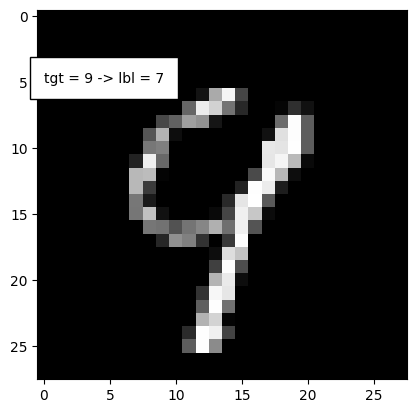

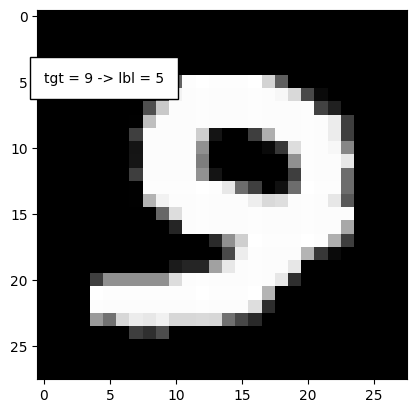

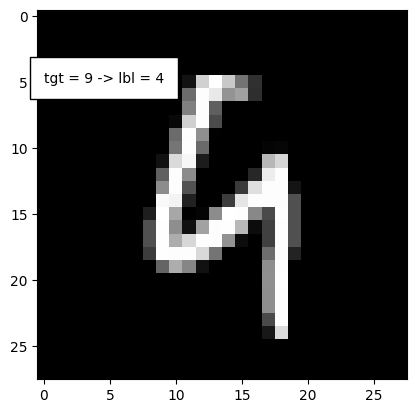

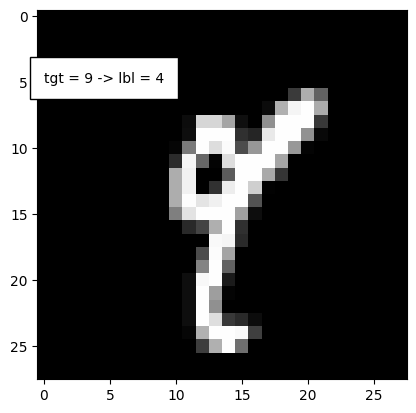

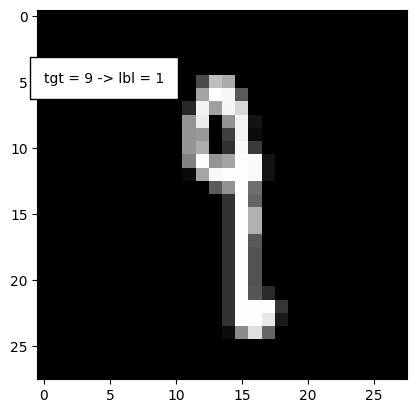

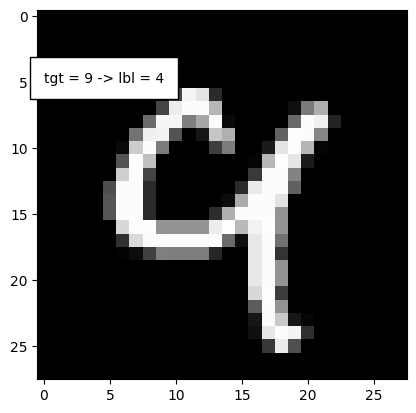

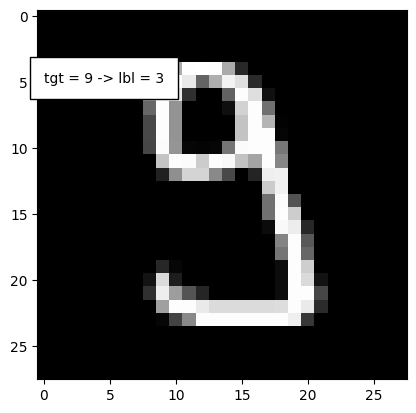

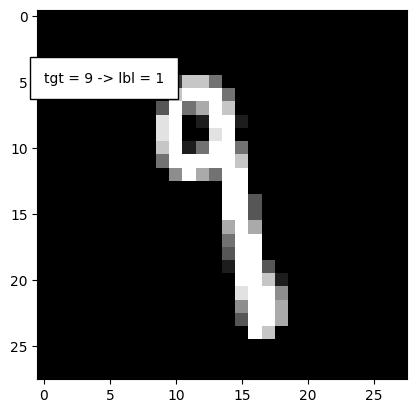

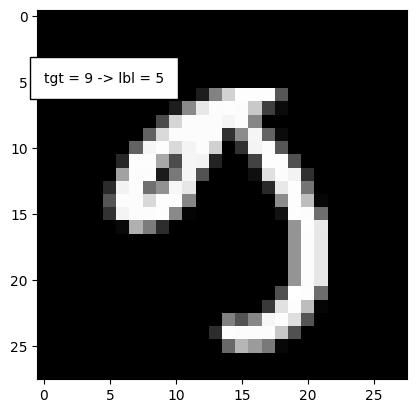

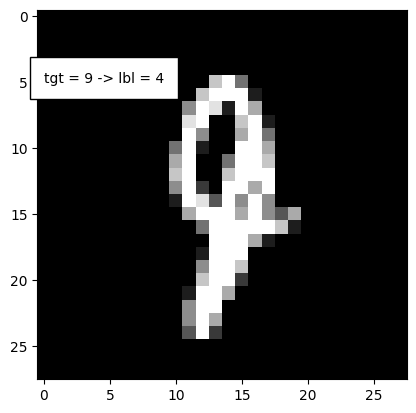

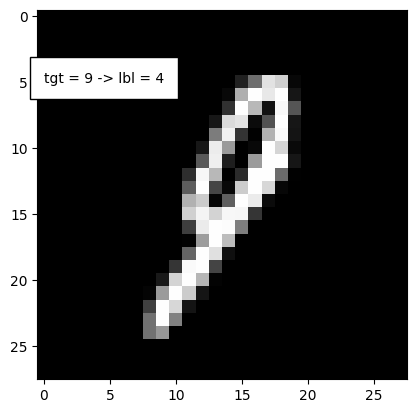

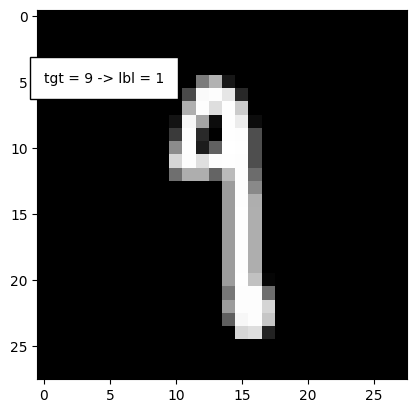

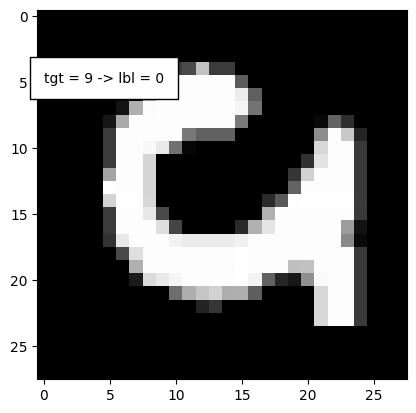

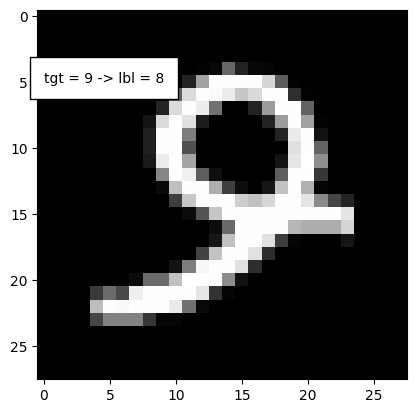

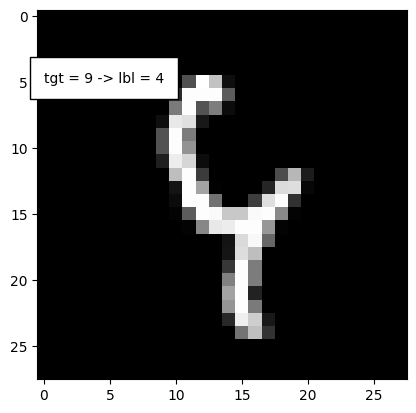

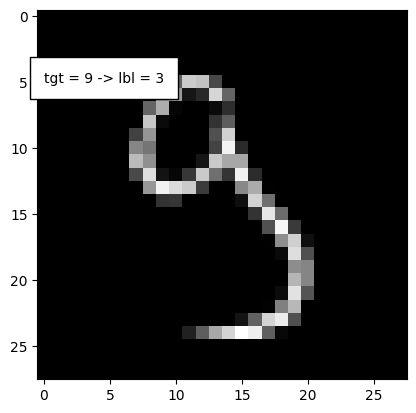

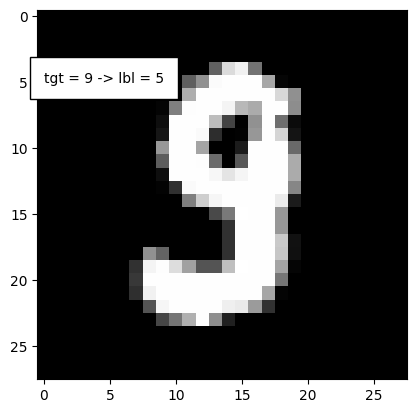

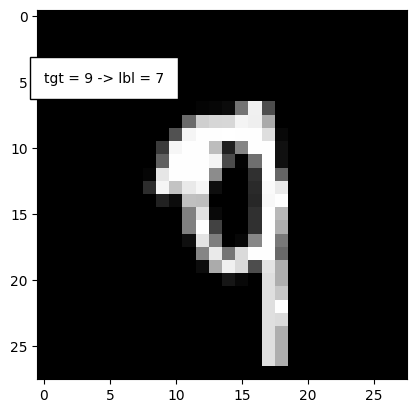

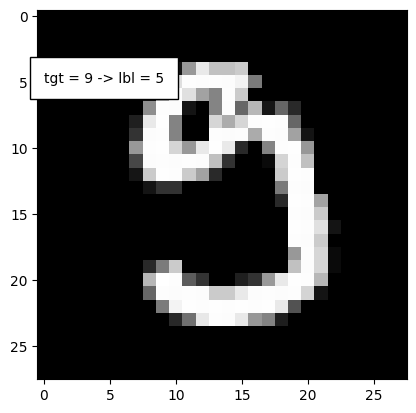

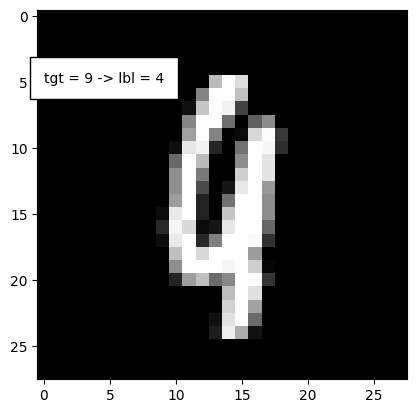

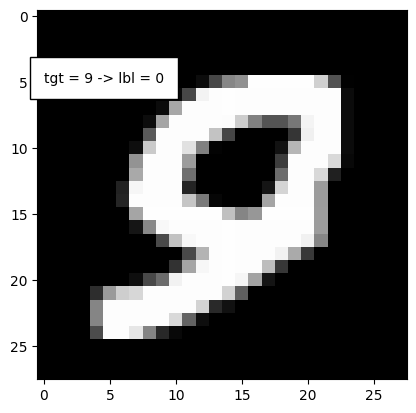

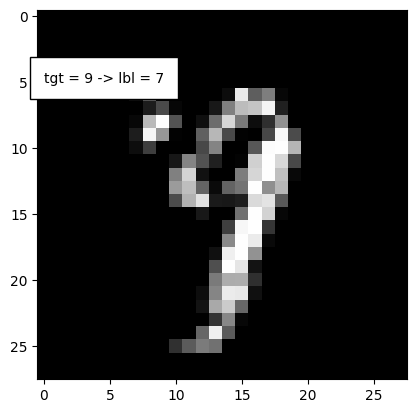

In [28]:
tmp = error_analysis_test_df[
    (error_analysis_test_df.target != error_analysis_test_df.label) &
    (error_analysis_test_df.target.isin([9]))
    ].sort_values("target", ascending = True)

for img, target, label in zip(tmp.images.values, tmp.target.values, tmp.label.values):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    leg = "tgt = "+ str(target)+" -> lbl = "+str(label)
    ax.text(0,5,leg, bbox={'facecolor': 'white', 'pad': 10})
    plt.show()

## Check for target = 8

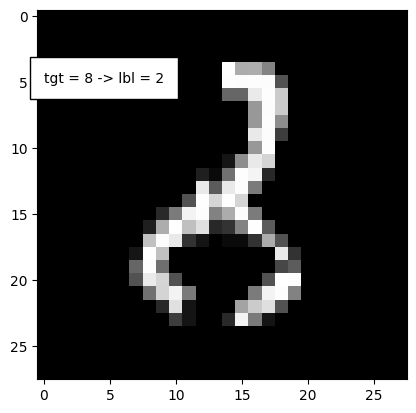

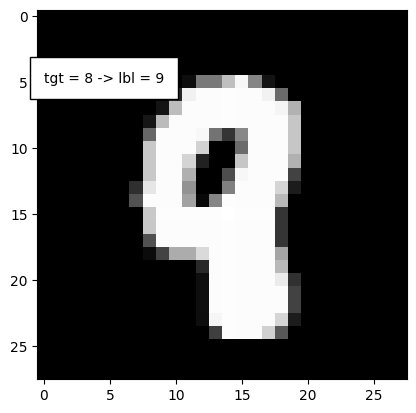

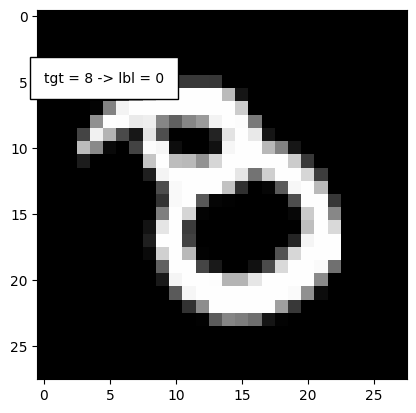

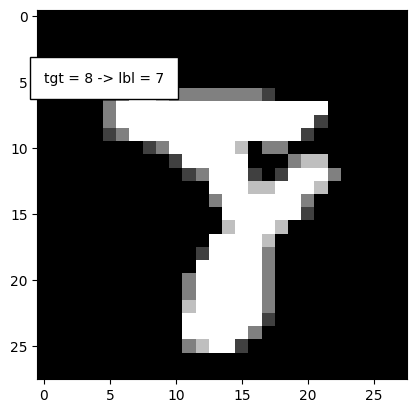

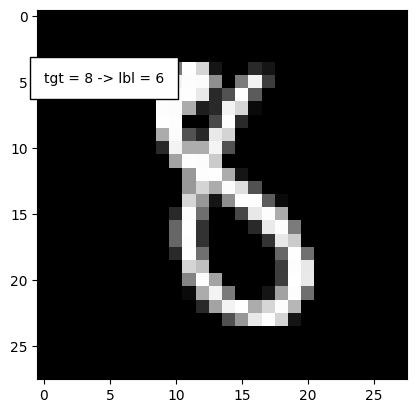

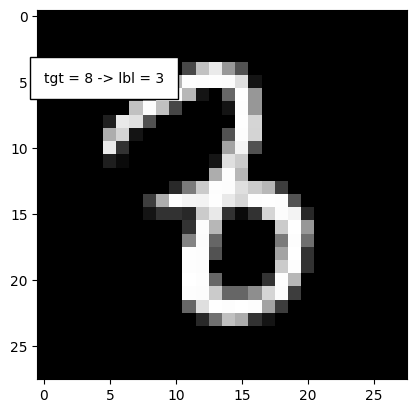

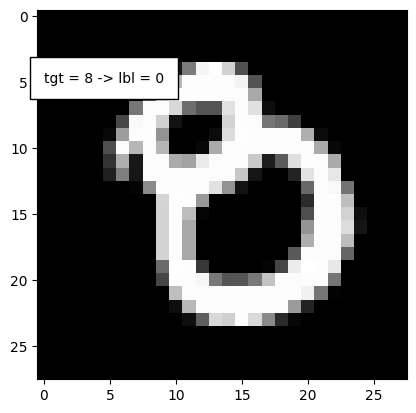

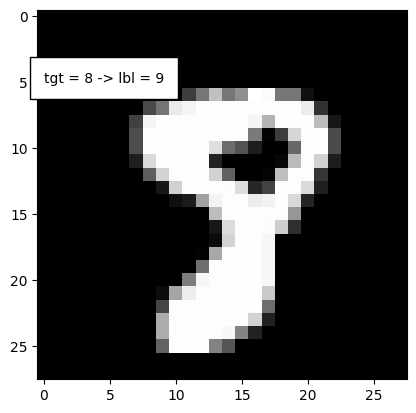

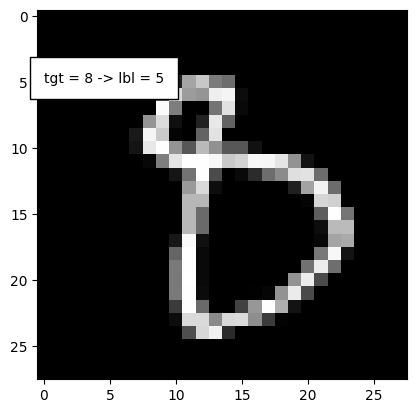

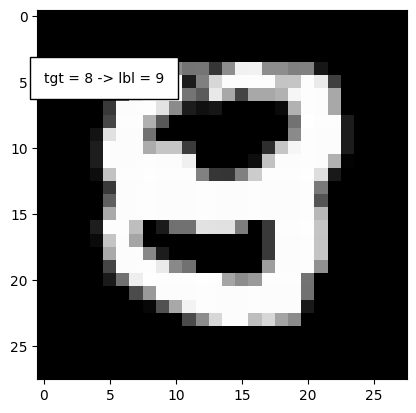

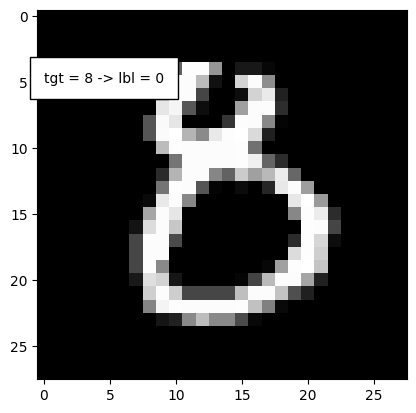

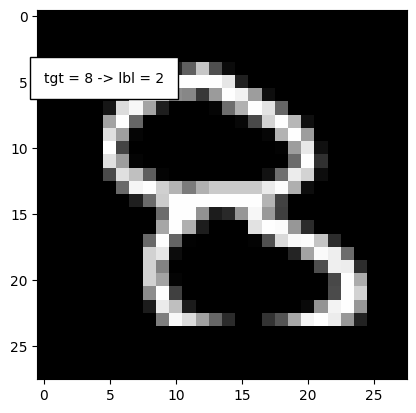

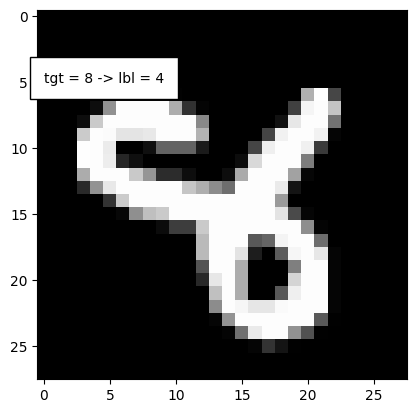

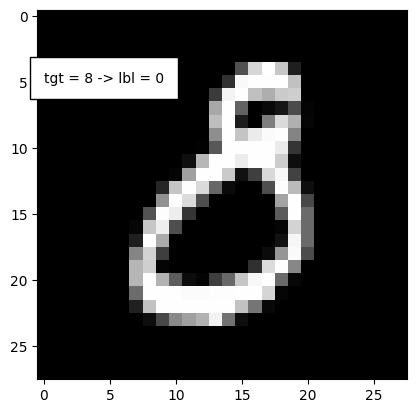

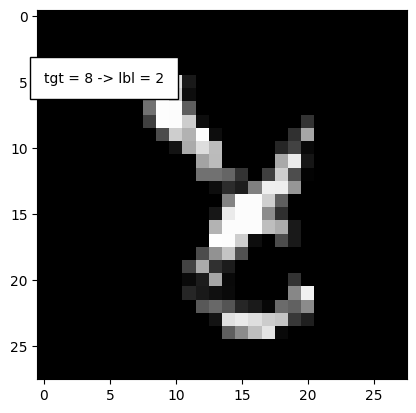

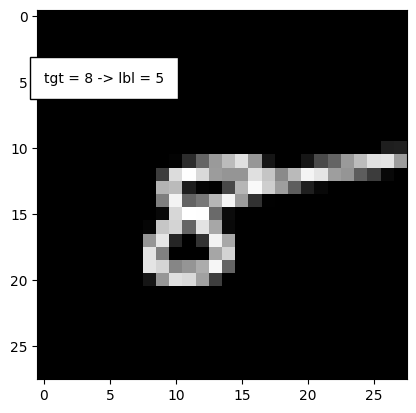

In [29]:
tmp = error_analysis_test_df[
    (error_analysis_test_df.target != error_analysis_test_df.label) &
    (error_analysis_test_df.target.isin([8]))
    ].sort_values("target", ascending = True)

for img, target, label in zip(tmp.images.values, tmp.target.values, tmp.label.values):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    leg = "tgt = "+ str(target)+" -> lbl = "+str(label)
    ax.text(0,5,leg, bbox={'facecolor': 'white', 'pad': 10})
    plt.show()

## Check for target = 7

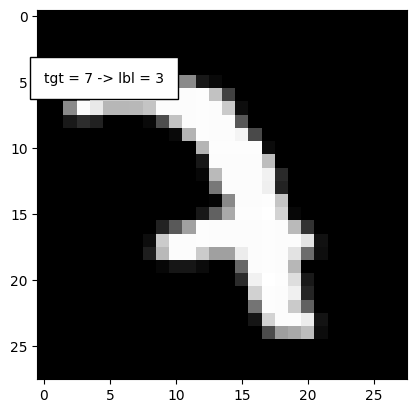

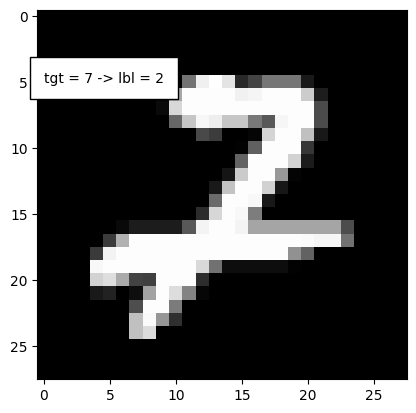

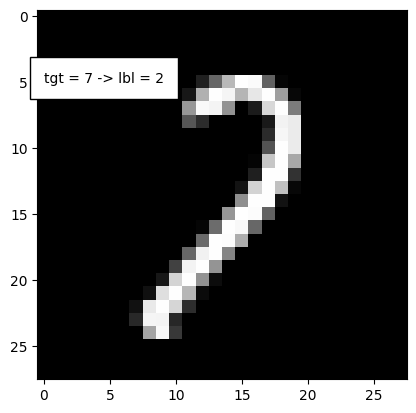

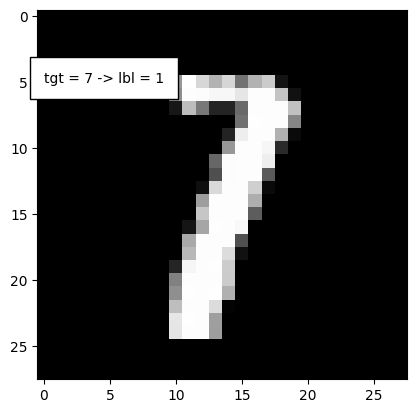

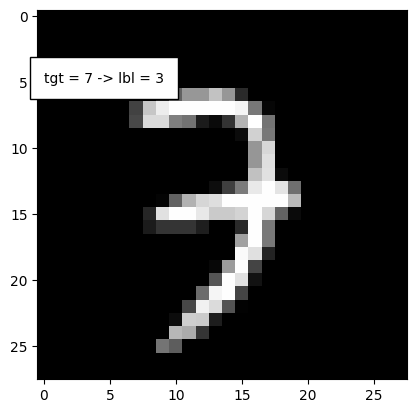

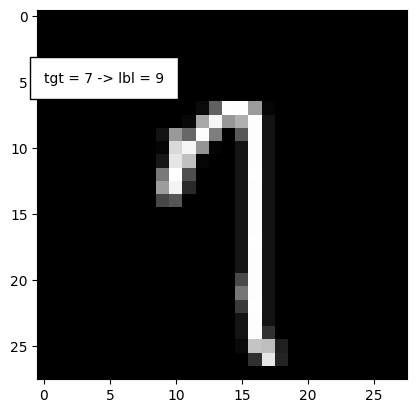

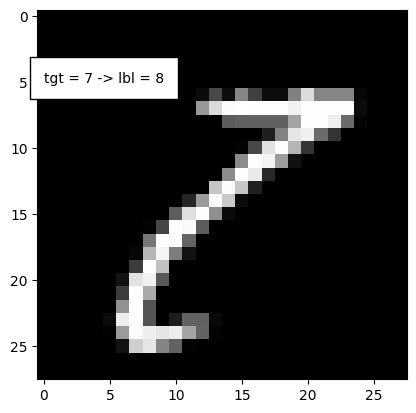

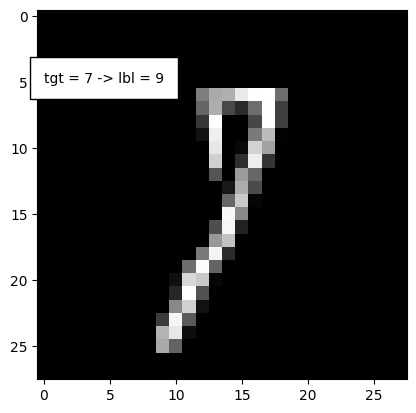

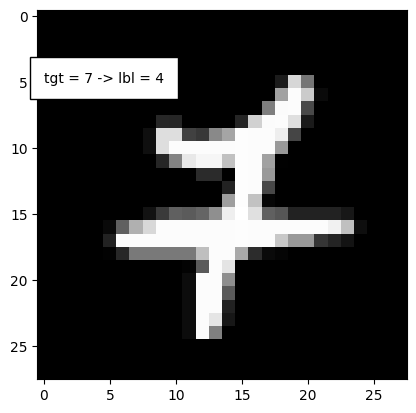

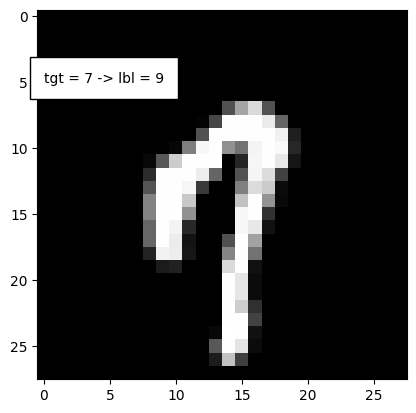

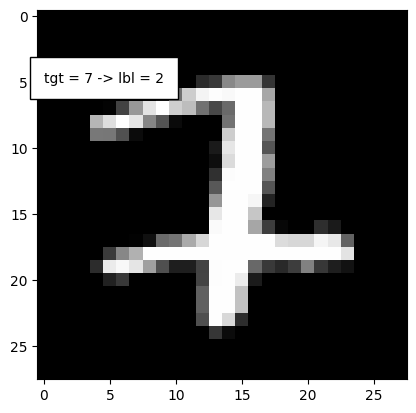

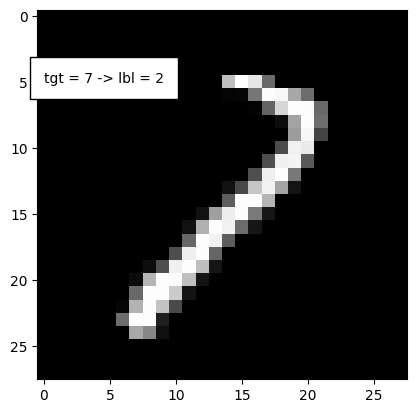

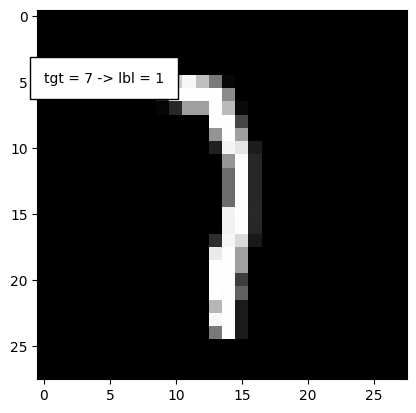

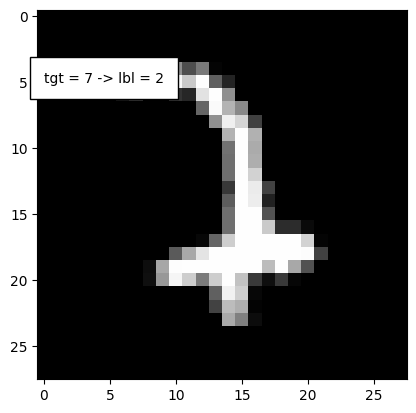

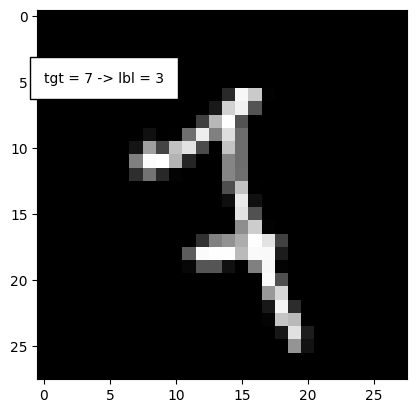

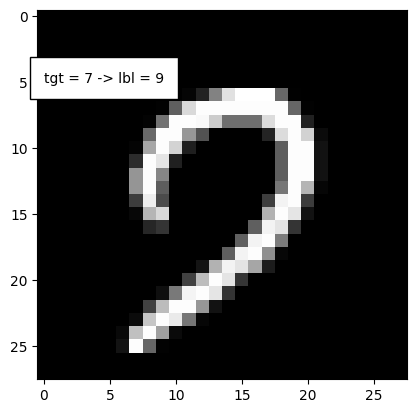

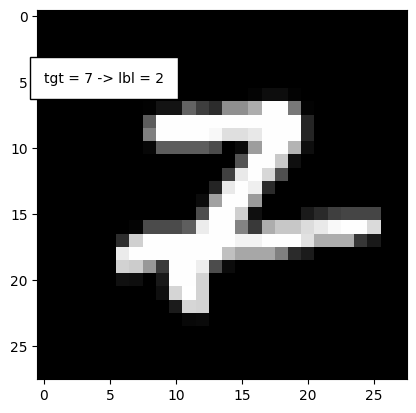

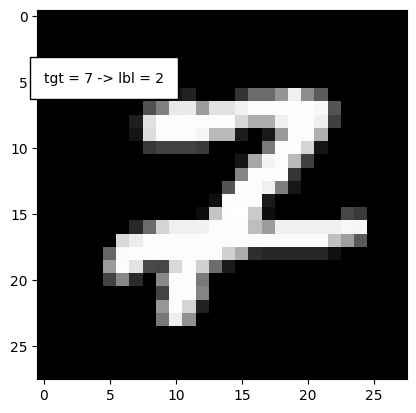

In [30]:
tmp = error_analysis_test_df[
    (error_analysis_test_df.target != error_analysis_test_df.label) &
    (error_analysis_test_df.target.isin([7]))
    ].sort_values("target", ascending = True)

for img, target, label in zip(tmp.images.values, tmp.target.values, tmp.label.values):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    leg = "tgt = "+ str(target)+" -> lbl = "+str(label)
    ax.text(0,5,leg, bbox={'facecolor': 'white', 'pad': 10})
    plt.show()

## Rotate, crop, RGB Experiments

In [35]:

train_agumented_df =  train_df[["images_rgb","label"]]
test_df =  test_df[["images_rgb","label"]]

In [36]:
def data_aug( img, label):
    X_temp = []
    Y_temp = []


    #**********IMAGE ROTATION*****************
    #if label != 6 and label != 9:
    
    # if label != 6 and label != 9:
    #     X_temp.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
    #     Y_temp.append(label)

    #     X_temp.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    #     Y_temp.append(label)

    #     X_temp.append(cv2.rotate(img, cv2.ROTATE_180))
    #     Y_temp.append(label)
    
    # if label != 2 and label != 5 and label != 6 and label != 9:
    #     X_temp.append(cv2.flip(img, 0))
    #     Y_temp.append(label)
    
    #**********IMAGE TRANSLATION*****************
    rows, cols, dim = img.shape
    # transformation matrix for translation
    # M = np.float32([[1, 0, 3],
    #                 [0, 1, 3],
    #                 [0, 0, 1]])
    # # apply a perspective transformation to the image
    # X_temp.append(cv2.warpPerspective(img, M, (cols, rows)))
    # Y_temp.append(label)
    
    # # transformation matrix for translation
    # M = np.float32([[1, 0.3, 0.3],
    #                 [0, 1, 0],
    #                 [0, 0, 1]])
    # # apply a perspective transformation to the image
    # X_temp.append(cv2.warpPerspective(img, M, (cols, rows)))
    # Y_temp.append(label)

    # # transformation matrix for translation
    # M = np.float32([[0.7, 0, 0],
    #                 [0.2, 1, 0],
    #                 [0, 0, 1]])
    # # apply a perspective transformation to the image
    # X_temp.append(cv2.warpPerspective(img, M, (cols, rows)))
    # Y_temp.append(label)
    
    
    #**********IMAGE SHEARING X AXIS*****************
    M = np.float32([[1, 0.5, 0],
                    [0, 1  , 0],
                    [0, 0  , 1]])
    # apply a perspective transformation to the image  
    image_tmp = cv2.warpPerspective(img,M,(int(cols),int(rows)))
    
    X_temp.append(image_tmp)
    Y_temp.append(label)


    # #**********IMAGE SHEARING Y AXIS*****************
    M = np.float32([[1,   0, 0],
                    [0.3, 1, 0],
                    [0,   0, 1]])
    # apply a perspective transformation to the image                
    X_temp.append(cv2.warpPerspective(img,M,(int(cols),int(rows))))
    Y_temp.append(label)

    return X_temp,Y_temp


tmp = train_agumented_df#[(train_agumented_df.label.isin([7,8,9]))]

for img, label in zip(tmp.images_rgb.values, tmp.label.values):
    # fig, ax = plt.subplots(1)
    # ax.imshow(img)
    # leg = "tgt = "+ str(label)
    # ax.text(0,5,leg, bbox={'facecolor': 'white', 'pad': 10})
    # plt.show()
        
    X_list, Y_list  = data_aug( img, label)
    # for img, target in zip(X_list, Y_list):
    #     fig, ax = plt.subplots(1)
    #     ax.imshow(img)
    #     leg = "tgt = "+ str(target)
    #     ax.text(0,5,leg, bbox={'facecolor': 'white', 'pad': 10})
    #     plt.show()
    # break
    tmp_df = pd.DataFrame({'images_rgb': [img for img in X_list]})
    tmp_df["label"] = Y_list
    train_agumented_df = pd.concat([train_agumented_df, tmp_df], axis = 0 )

In [37]:
train_agumented_df.shape

(180000, 2)

<Axes: >

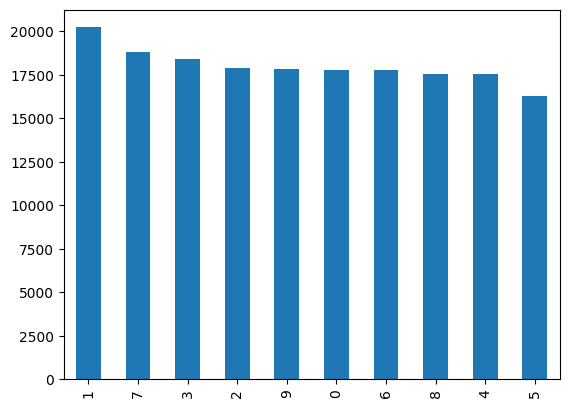

In [38]:
train_agumented_df.label.value_counts().plot(kind="bar")

# Retraining with new data 

In [42]:

stage = "data_augmentation"
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(W, H, 3)))#128
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(W, H, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(160, (3, 3), activation='relu', input_shape=(W, H, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.00001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['sparse_categorical_accuracy'])

In [43]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/{stage}/")

train_input = np.array([img for img in train_agumented_df.images_rgb.values]).reshape(len(train_agumented_df), W, H, 3)
test_input = np.array([img for img in test_df.images_rgb.values]).reshape(len(test_df), W, H, 3)

y_train = train_agumented_df.label.values
y_test = test_df.label.values

model.fit(train_input, 
          y_train , 
          #validation_split= 0.05, 
          validation_data=(test_input, y_test),
          epochs= 300, 
          batch_size = 1024,
          callbacks=[tensorboard_callback]
          )
model.save_weights('./checkpoints/model_v2')
#model.load_weights('./checkpoints/model_v2')

Epoch 1/300
176/176 [==============================] - 8s 41ms/step - loss: 0.9421 - sparse_categorical_accuracy: 0.7013 - val_loss: 0.5382 - val_sparse_categorical_accuracy: 0.8556
Epoch 2/300
176/176 [==============================] - 7s 41ms/step - loss: 0.3287 - sparse_categorical_accuracy: 0.9046 - val_loss: 0.2648 - val_sparse_categorical_accuracy: 0.9260
Epoch 3/300
176/176 [==============================] - 7s 40ms/step - loss: 0.2232 - sparse_categorical_accuracy: 0.9361 - val_loss: 0.1919 - val_sparse_categorical_accuracy: 0.9430
Epoch 4/300
176/176 [==============================] - 7s 40ms/step - loss: 0.1745 - sparse_categorical_accuracy: 0.9497 - val_loss: 0.1597 - val_sparse_categorical_accuracy: 0.9528
Epoch 5/300
176/176 [==============================] - 7s 40ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.9581 - val_loss: 0.1392 - val_sparse_categorical_accuracy: 0.9586
Epoch 6/300
176/176 [==============================] - 7s 40ms/step - loss: 0.1253 - spars

In [ ]:
error_analysis_df = pd.DataFrame(y_test, columns = ["target"])
error_analysis_df["images"] = test_df[["images_rgb"]]
error_analysis_df

In [ ]:
test_target_prob = model.predict(test_input)
error_analysis_df["label"] = test_target_prob.argmax(axis=-1)
error_analysis_df["target_prob"] = test_target_prob.max(axis  =-1)
error_analysis_df

In [ ]:
multilabel_confusion_matrix(error_analysis_df.target, error_analysis_df.label)

In [ ]:
error_analysis_df[
    (error_analysis_df.target != error_analysis_df.label)
    ].target.value_counts() 